In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import train
import pickle


In [ ]:
dfList = train.transform("data.json")
#df.shape

In [ ]:
df1List = dfList
dfList = df1List
for df in dfList:
    scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
    df = scaler.transform(df)
#print(dfList[12])
#print(dfList[0].head(5))

In [2]:
def eval(accList, precisionList, tprList, farList, frrList, y, y_pred):
    avgaccuracy = 0
    avgPrecision = 0
    avgTpr = 0
    avgFar = 0
    avgFrr = 0
    for i in range(len(accList)):
        avgaccuracy += accList[i]
        avgPrecision += precisionList[i]
        avgTpr += tprList[i]
        avgFar += farList[i]
        avgFrr += frrList[i]
    avgaccuracy = avgaccuracy / len(accList)
    avgPrecision = avgPrecision / len(precisionList)
    avgTpr = avgTpr / len(tprList)
    avgFar = avgFar / len(farList)
    avgFrr = avgFrr / len(frrList)
    
    fprROC, tprROC, threshold = roc_curve(y, y_pred, pos_label=1) #fprROC == avgFar, tprROC == avgTpr
    fnrROC = 1 - tprROC #fnrROC == avgFrr
    EER = fprROC[np.nanargmin(np.absolute((fnrROC - fprROC)))]

    print("average acc = "+str(avgaccuracy))
    print("average precision = "+str(avgPrecision))
    print("average TPR = "+str(avgTpr))
    print("average FAR = "+str(avgFar))
    print("average FRR = "+str(avgFrr))
    print("average EER = "+str(EER))

In [ ]:
#Truly train the RF models that are going to be used

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

i=0
for df in dfList: 
    X = df.drop(columns=['label'])
    X = X.drop(columns=['pressureMedian'])
    X = X.drop(columns=['sizeMedian'])

    y = df['label']
    predicted_targets = np.array([])
    actual_targets = np.array([])
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y) #stratify=y means to keep the same ratio of labels in test set as the training set
    X_re, y_re = SMOTE(random_state=42, k_neighbors=2).fit_resample(X_train, y_train.astype('int')) #only apply SMOTE on training dataset
    #X_re, y_re = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train.astype('int'))
    
    RF_model = RandomForestClassifier(n_estimators=22)
    RF_model.fit(X_re,y_re)
    
    y_pred = RF_model.predict(X_test)
    predicted_targets = np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y_test)
    
    cm = confusion_matrix(actual_targets.astype('int'), predicted_targets)
    
    plt.figure(figsize=(12,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()
    
    
    tn, fp, fn, tp = cm.ravel()
    tnTotal += tn
    fpTotal += fp
    fnTotal += fn
    tpTotal += tp
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    far = fp/(fp+tn)
    frr = fn/(fn+tp)
    
    accList.append(accuracy)
    precisionList.append(precision)
    tprList.append(tpr)
    farList.append(far)
    frrList.append(frr)
    
    print("acc = "+str(accuracy))
    print("precision = "+str(precision))
    print("TPR = "+str(tpr))
    print("FAR = "+str(far))
    print("FRR = "+str(frr))

    initial_types = [
        ('input_data_type', FloatTensorType([None, 54]))
    ]

    converted_model = convert_sklearn(RF_model, initial_types=initial_types)
    with open(f"./models/model{i}.onnx", "wb") as f:
        f.write(converted_model.SerializeToString())
    i+=1
    
    
eval(tnTotal, fpTotal, fnTotal, tpTotal, actual_targets.astype('int'), predicted_targets, len(dfList))

plt.figure(figsize=(12,5))
sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()


In [ ]:
df = train.onlyOneUser("temp.json", "1094842")
#["1092954", "dama0623", "1094908", "4109034029", "611034", "1094841", "D1186959",
#                "411411159", "1094845", "1094842", "110", "pomiii5093", "1092574", "anyu5471", "px",
#                "wardlin", "lenny", "1092960", "1092923", "1092950", "1092942", "1092928", "1092922"]
#scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
#df = scaler.transform(df)

In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

y = df['label']
X = df.drop(columns=['label'])
X = X.drop(columns=['pressureMedian'])
X = X.drop(columns=['sizeMedian'])

predicted_targets = np.array([])
actual_targets = np.array([])

sess = rt.InferenceSession(
        f"./models/SMOTERF-newData/model9.onnx", providers=rt.get_available_providers())
input_name = sess.get_inputs()[0].name
    #print(X_test.astype(np.float32).to_dict('split')['data'])
    #break
y_pred = sess.run(None, {input_name: X.astype(np.float32).to_dict('split')['data']})[0]

predicted_targets = np.append(predicted_targets, y_pred)
actual_targets = np.append(actual_targets, y)

cm = confusion_matrix(actual_targets.astype('int'), predicted_targets.astype('int'), labels=[False, True])
plt.figure(figsize=(12,5))
sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()

tn, fp, fn, tp = cm.ravel()
tnTotal += tn
fpTotal += fp
fnTotal += fn
tpTotal += tp

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
tpr = tp/(tp+fn)
far = fp/(fp+tn)
frr = fn/(fn+tp)

accList.append(accuracy)
precisionList.append(precision)
tprList.append(tpr)
farList.append(far)
frrList.append(frr)

print("acc = "+str(accuracy))
print("precision = "+str(precision))
print("TPR = "+str(tpr))
print("FAR = "+str(far))
print("FRR = "+str(frr))
    
#eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)
#plt.figure(figsize=(12,5))
#sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
#plt.xlabel('Pred',fontsize=20)
#plt.ylabel('True',fontsize=20)
#plt.show()


In [3]:
dfList = train.addNewData()

df1List = dfList
dfList = df1List
for df in dfList:
    scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
    df = scaler.transform(df)

c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:30: FutureWarning: The behavi

110


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


119


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


133


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


107


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


114


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


81


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


118


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


92


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


106


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


117


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


106


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


117


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


108


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


159


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


136


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


123


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


110


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


78


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


67


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


80
56
85


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])
c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


89


c:\Users\islab\Downloads\1092928\android-project-main\android-project-main_1\android-project-main\train.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1])


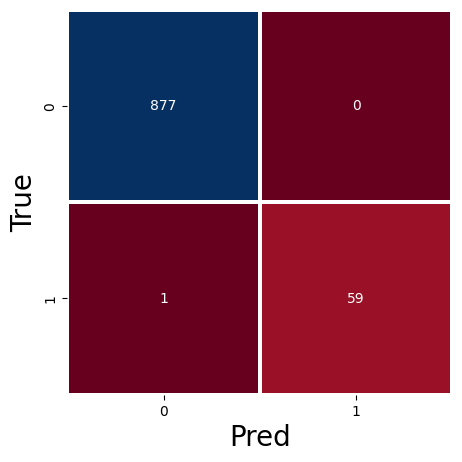

acc = 0.9989327641408752
precision = 1.0
TPR = 0.9833333333333333
FAR = 0.0
FRR = 0.016666666666666666


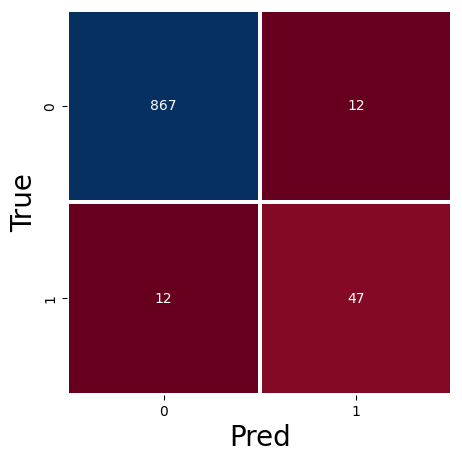

acc = 0.9744136460554371
precision = 0.7966101694915254
TPR = 0.7966101694915254
FAR = 0.013651877133105802
FRR = 0.2033898305084746


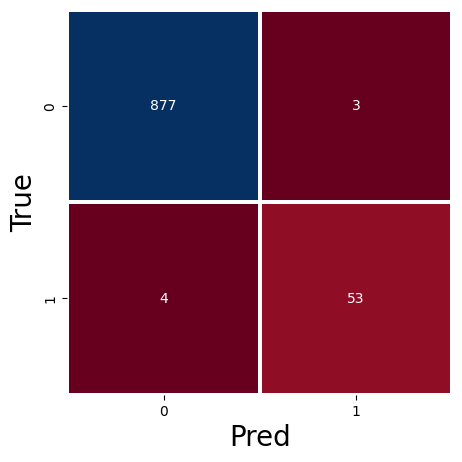

acc = 0.9925293489861259
precision = 0.9464285714285714
TPR = 0.9298245614035088
FAR = 0.003409090909090909
FRR = 0.07017543859649122


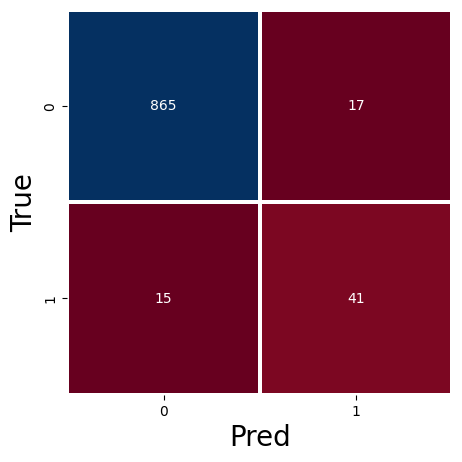

acc = 0.9658848614072495
precision = 0.7068965517241379
TPR = 0.7321428571428571
FAR = 0.01927437641723356
FRR = 0.26785714285714285


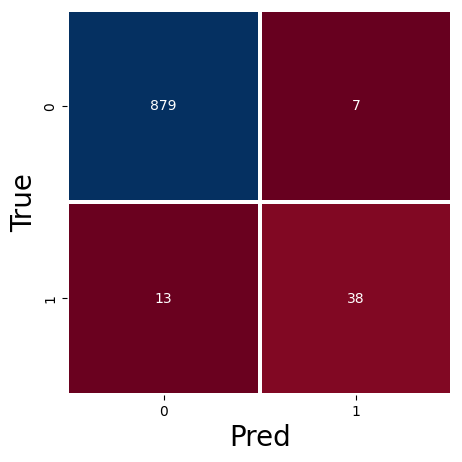

acc = 0.9786552828175027
precision = 0.8444444444444444
TPR = 0.7450980392156863
FAR = 0.007900677200902935
FRR = 0.2549019607843137


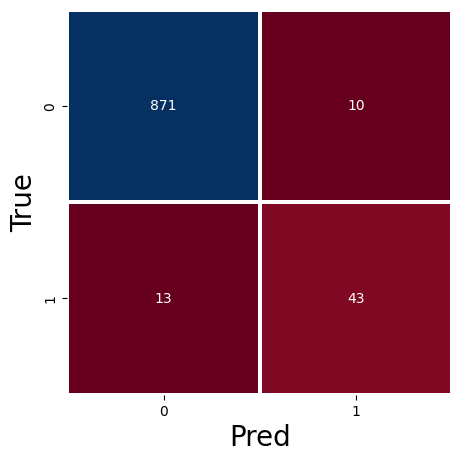

acc = 0.9754535752401281
precision = 0.8113207547169812
TPR = 0.7678571428571429
FAR = 0.011350737797956867
FRR = 0.23214285714285715


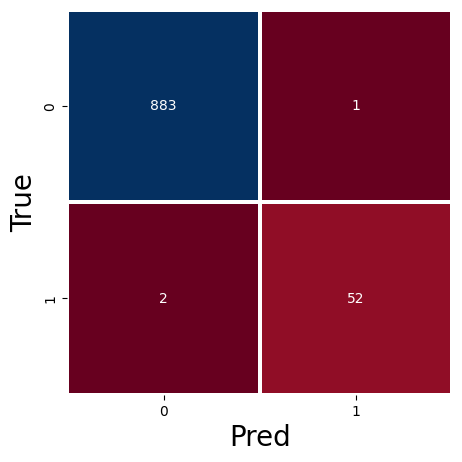

acc = 0.9968017057569296
precision = 0.9811320754716981
TPR = 0.9629629629629629
FAR = 0.0011312217194570137
FRR = 0.037037037037037035


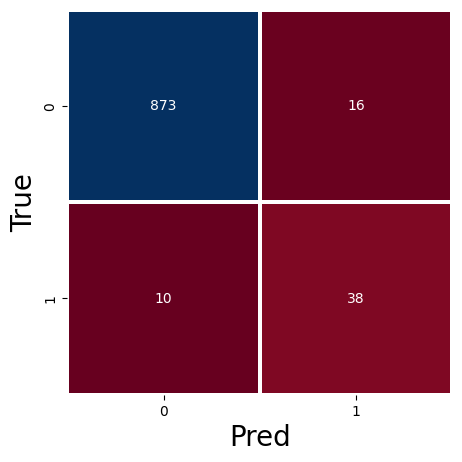

acc = 0.9722518676627535
precision = 0.7037037037037037
TPR = 0.7916666666666666
FAR = 0.01799775028121485
FRR = 0.20833333333333334


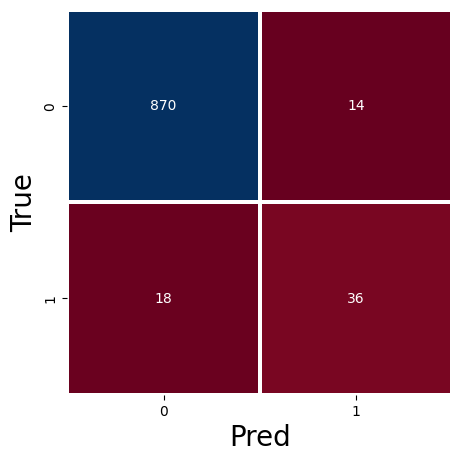

acc = 0.9658848614072495
precision = 0.72
TPR = 0.6666666666666666
FAR = 0.01583710407239819
FRR = 0.3333333333333333


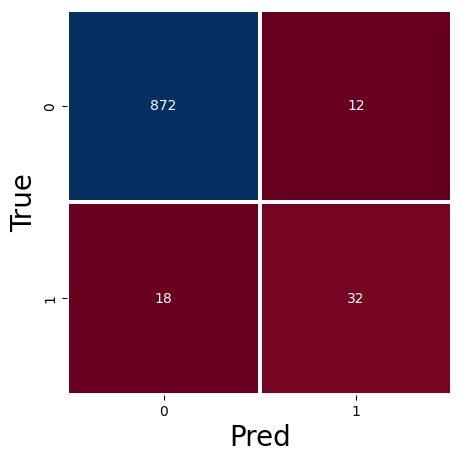

acc = 0.9678800856531049
precision = 0.7272727272727273
TPR = 0.64
FAR = 0.013574660633484163
FRR = 0.36


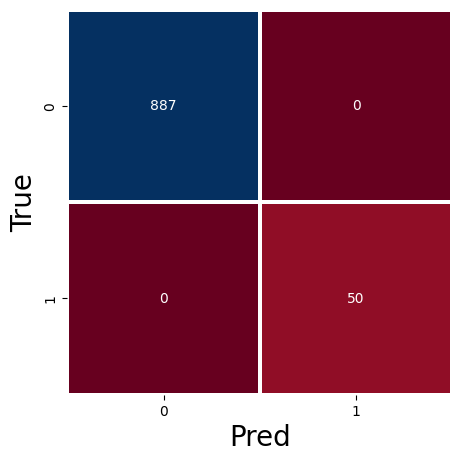

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0


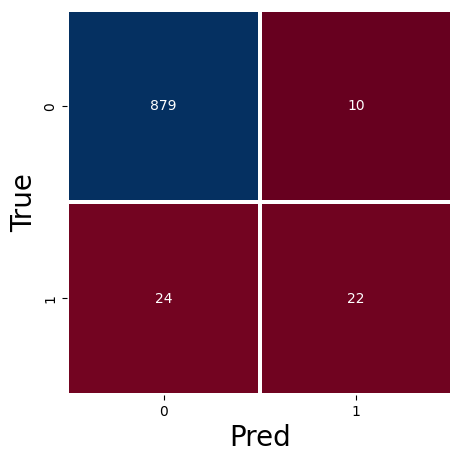

acc = 0.9636363636363636
precision = 0.6875
TPR = 0.4782608695652174
FAR = 0.01124859392575928
FRR = 0.5217391304347826


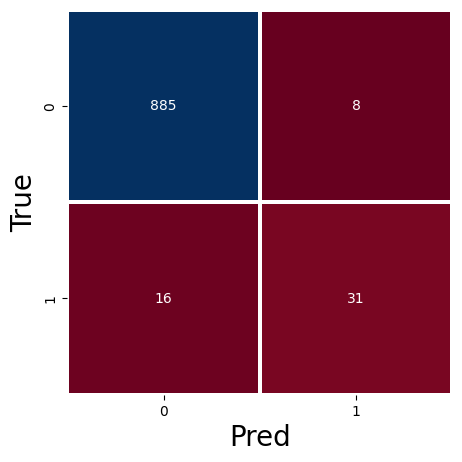

acc = 0.9744680851063829
precision = 0.7948717948717948
TPR = 0.6595744680851063
FAR = 0.008958566629339306
FRR = 0.3404255319148936


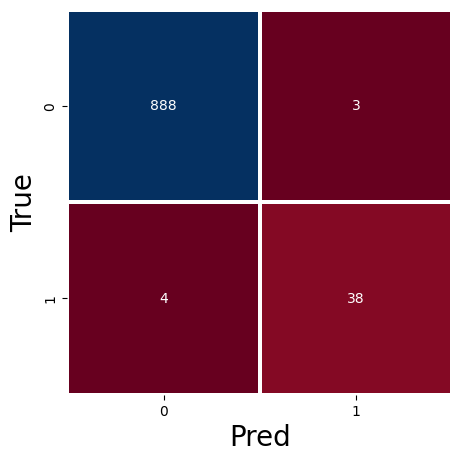

acc = 0.992497320471597
precision = 0.926829268292683
TPR = 0.9047619047619048
FAR = 0.003367003367003367
FRR = 0.09523809523809523


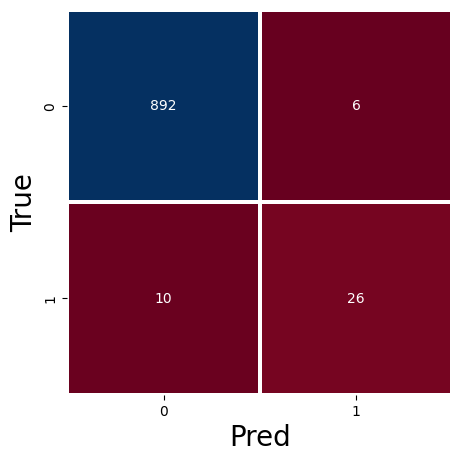

acc = 0.9828693790149893
precision = 0.8125
TPR = 0.7222222222222222
FAR = 0.0066815144766146995
FRR = 0.2777777777777778


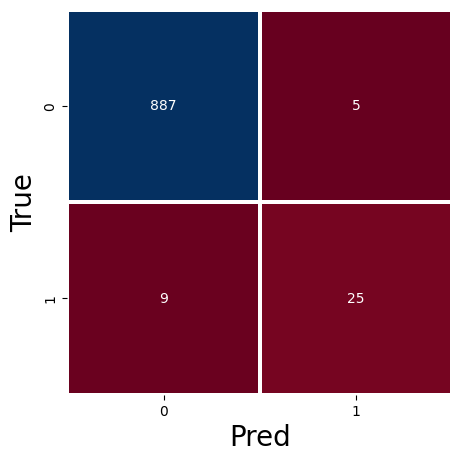

acc = 0.9848812095032398
precision = 0.8333333333333334
TPR = 0.7352941176470589
FAR = 0.005605381165919282
FRR = 0.2647058823529412


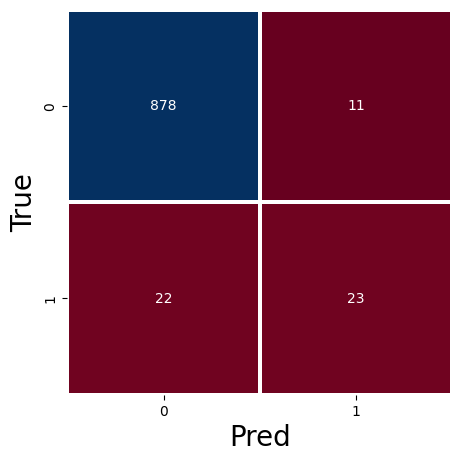

acc = 0.9646680942184154
precision = 0.6764705882352942
TPR = 0.5111111111111111
FAR = 0.012373453318335208
FRR = 0.4888888888888889


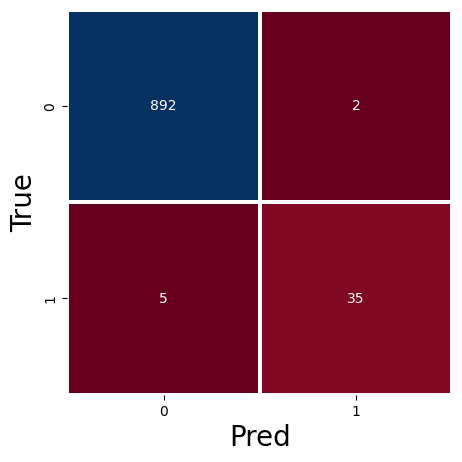

acc = 0.9925053533190579
precision = 0.9459459459459459
TPR = 0.875
FAR = 0.0022371364653243847
FRR = 0.125


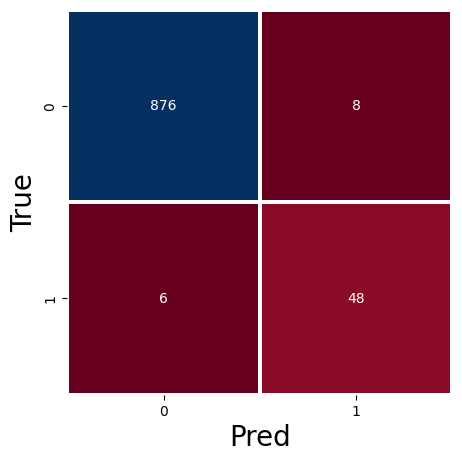

acc = 0.9850746268656716
precision = 0.8571428571428571
TPR = 0.8888888888888888
FAR = 0.00904977375565611
FRR = 0.1111111111111111


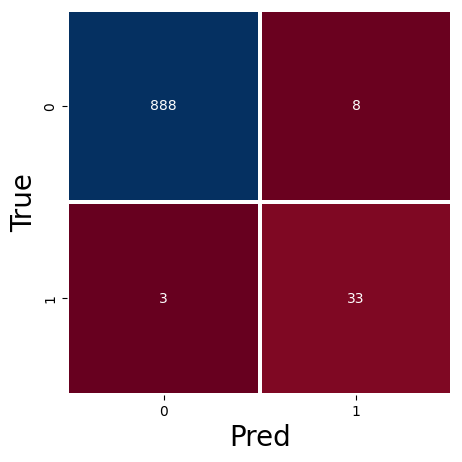

acc = 0.9881974248927039
precision = 0.8048780487804879
TPR = 0.9166666666666666
FAR = 0.008928571428571428
FRR = 0.08333333333333333


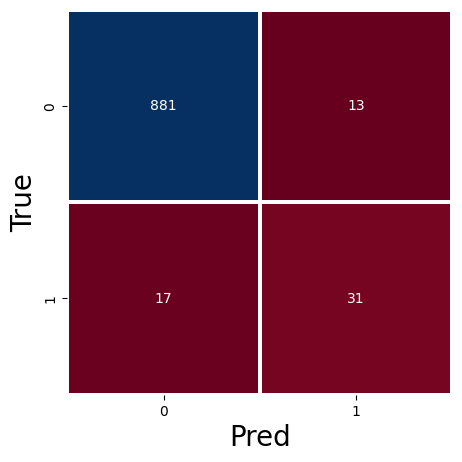

acc = 0.9681528662420382
precision = 0.7045454545454546
TPR = 0.6458333333333334
FAR = 0.0145413870246085
FRR = 0.3541666666666667


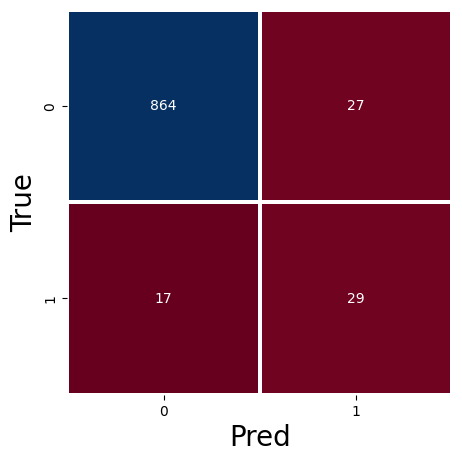

acc = 0.9530416221985059
precision = 0.5178571428571429
TPR = 0.6304347826086957
FAR = 0.030303030303030304
FRR = 0.3695652173913043


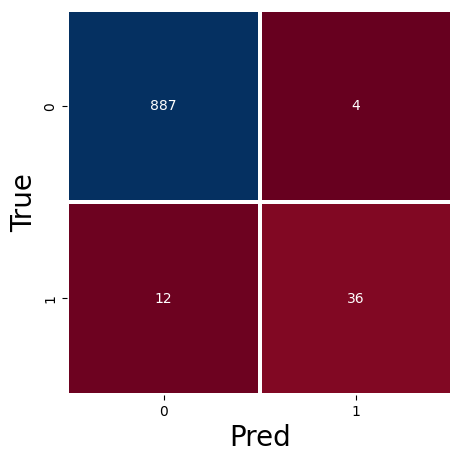

acc = 0.9829605963791267
precision = 0.9
TPR = 0.75
FAR = 0.004489337822671156
FRR = 0.25


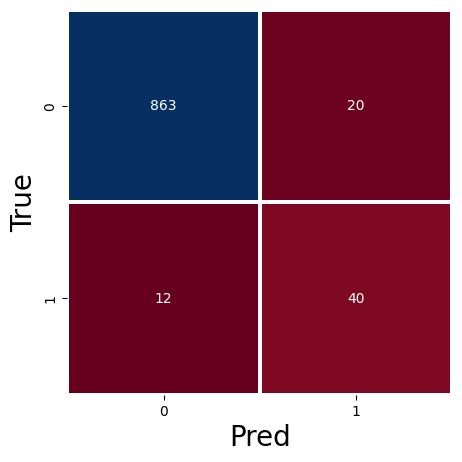

acc = 0.9657754010695188
precision = 0.6666666666666666
TPR = 0.7692307692307693
FAR = 0.022650056625141562
FRR = 0.23076923076923078
average acc = 0.9786423475852067
average precision = 0.8069312541218937
average TPR = 0.7709767305775551
average FAR = 0.010190054269700785
average FRR = 0.2290232694224448
average EER = 0.022650056625141562


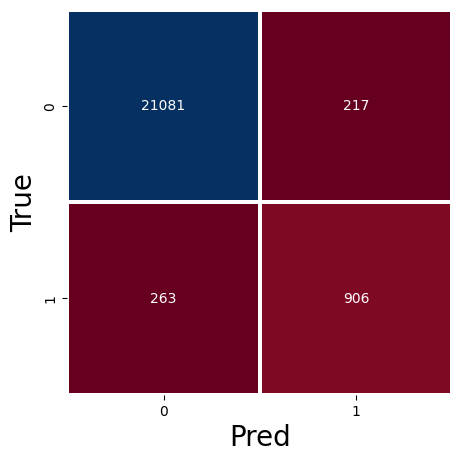

In [13]:
#Truly train the RF models that are going to be used

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

i=0
for df in dfList: 
    X = df.drop(columns=['label'])
    X = X.drop(columns=['pressureMedian'])
    #X = X.drop(columns=['sizeMedian'])
    '''
    X = X.drop(columns=['GXmax'])
    X = X.drop(columns=['GXmin'])
    X = X.drop(columns=['GXmean'])
    X = X.drop(columns=['GXmedian'])
    X = X.drop(columns=['GXSD'])
    X = X.drop(columns=['GYmax'])
    X = X.drop(columns=['GYmin'])
    X = X.drop(columns=['GYmean'])
    X = X.drop(columns=['GYmedian'])
    X = X.drop(columns=['GYSD'])
    X = X.drop(columns=['GZmax'])
    X = X.drop(columns=['GZmin'])
    X = X.drop(columns=['GZmean'])
    X = X.drop(columns=['GZmedian'])
    X = X.drop(columns=['GZSD'])
    '''
    X = X.drop(columns=['startX'])
    X = X.drop(columns=['startY'])
    X = X.drop(columns=['endX'])
    X = X.drop(columns=['endY'])

    X = X.drop(columns=['MXmax'])
    X = X.drop(columns=['MXmin'])
    X = X.drop(columns=['MXmean'])
    X = X.drop(columns=['MXmedian'])
    X = X.drop(columns=['MXSD'])
    X = X.drop(columns=['MYmax'])
    X = X.drop(columns=['MYmin'])
    X = X.drop(columns=['MYmean'])
    X = X.drop(columns=['MYmedian'])
    X = X.drop(columns=['MYSD'])
    X = X.drop(columns=['MZmax'])
    X = X.drop(columns=['MZmin'])
    X = X.drop(columns=['MZmean'])
    X = X.drop(columns=['MZmedian'])
    X = X.drop(columns=['MZSD'])

    y = df['label']
    predicted_targets = np.array([])
    actual_targets = np.array([])
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y) #stratify=y means to keep the same ratio of labels in test set as the training set
    X_re, y_re = SMOTE(random_state=42, k_neighbors=2).fit_resample(X_train, y_train.astype('int')) #only apply SMOTE on training dataset
    #X_re, y_re = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train.astype('int'))
    
    RF_model = RandomForestClassifier(n_estimators=22)
    RF_model.fit(X_re,y_re)
    
    #import pickle
    #pickle.dump(RF_model, open(f"./models/rf{i}.pickle", "wb"))
    
    y_pred = RF_model.predict(X_test)
    predicted_targets = np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y_test)
    
    cm = confusion_matrix(actual_targets.astype('int'), predicted_targets)
    
    plt.figure(figsize=(12,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()
    
    
    tn, fp, fn, tp = cm.ravel()
    tnTotal += tn
    fpTotal += fp
    fnTotal += fn
    tpTotal += tp
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    far = fp/(fp+tn)
    frr = fn/(fn+tp)
    
    accList.append(accuracy)
    precisionList.append(precision)
    tprList.append(tpr)
    farList.append(far)
    frrList.append(frr)
    
    print("acc = "+str(accuracy))
    print("precision = "+str(precision))
    print("TPR = "+str(tpr))
    print("FAR = "+str(far))
    print("FRR = "+str(frr))

    initial_types = [
        ('input_data_type', FloatTensorType([None, 36]))
    ]

    converted_model = convert_sklearn(RF_model, initial_types=initial_types)
    with open(f"./models/model{i}.onnx", "wb") as f:
        f.write(converted_model.SerializeToString())
    i+=1
    
eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)

plt.figure(figsize=(12,5))
sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()

In [ ]:
dfList = train.transform("temp.json")

#for df in dfList:
#    scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
#    df = scaler.transform(df)

In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt
import json

userOrder = []
userList = ["1092954", "dama0623", "1094908", "4109034029", "611034", "1094841", "D1186959",
                "411411159", "1094845", "1094842", "110", "pomiii5093", "1092574", "anyu5471", "px",
                "wardlin", "lenny", "1092960", "1092923", "1092950", "1092942", "1092928", "1092922", "29282928"]

with open("evaluationData.json", 'r') as f:
    data = json.load(f)
    numSubject = len(data)
    for i in data.keys():
        userOrder.append(userList.index(i))
        
i=0

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

for df in dfList:
    y = df['label']
    X = df.drop(columns=['label'])
    X = X.drop(columns=['pressureMedian'])
    X = X.drop(columns=['sizeMedian'])

    predicted_targets = np.array([])
    actual_targets = np.array([])

    sess = rt.InferenceSession(
            #f"./models/SMOTERF-newData/model{userOrder[i]}.onnx", providers=rt.get_available_providers())
            f"./models/RandomSamplingRF-newData/model{userOrder[i]}.onnx", providers=rt.get_available_providers())
            #f"./models/model{userOrder[i]}.onnx", providers=rt.get_available_providers())
    
    input_name = sess.get_inputs()[0].name
        #print(X_test.astype(np.float32).to_dict('split')['data'])
        #break
    y_pred = sess.run(None, {input_name: X.astype(np.float32).to_dict('split')['data']})[0]

    predicted_targets = np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y)

    print("NOW SHOWING: " + str(userList[userOrder[i]]))
    cm = confusion_matrix(actual_targets.astype('int'), predicted_targets.astype('int'), labels=[False, True])
    plt.figure(figsize=(12,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    tnTotal += tn
    fpTotal += fp
    fnTotal += fn
    tpTotal += tp

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    far = fp/(fp+tn)
    frr = fn/(fn+tp)

    accList.append(accuracy)
    precisionList.append(precision)
    tprList.append(tpr)
    farList.append(far)
    frrList.append(frr)

    print("acc = "+str(accuracy))
    print("precision = "+str(precision))
    print("TPR = "+str(tpr))
    print("FAR = "+str(far))
    print("FRR = "+str(frr))
    i+=1
    
eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)

plt.figure(figsize=(12,5))
sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()
